In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

In [2]:
import pickle
import gzip

with gzip.open( (PATH / FILENAME).as_posix(), "rb" ) as f:
    print(f)
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

<gzip _io.BufferedReader name='data/mnist/mnist.pkl.gz' 0x1f318b06b88>


(50000, 784)


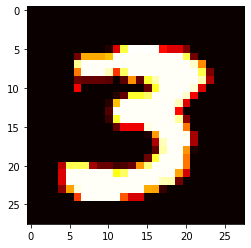

In [3]:
%matplotlib inline
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[27].reshape((28, 28)), cmap="hot")
print(x_train.shape)

In [4]:
import torch

In [5]:
x_train, y_train, x_valid, y_valid = map( torch.tensor, (x_train, y_train, x_valid, y_valid) )
n, c = x_train.shape
n, c

(50000, 784)

In [6]:
print(y_train, y_train.shape)
print(y_train.min(), y_train.max())

tensor([5, 0, 4,  ..., 8, 4, 8]) torch.Size([50000])
tensor(0) tensor(9)


In [7]:
bs = 64  # 一批数据个数

xb = x_train[0:bs]  # 从x获取一小批数据
print(xb.shape)

torch.Size([64, 784])


In [8]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [9]:
from IPython.core.debugger import set_trace

epochs = 2  # 训练的轮数

In [10]:
from torch import nn, optim
import torch.nn.functional as F

loss_func = F.cross_entropy

In [11]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [12]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [13]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [14]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    
    for epoch in range(epochs):
        
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print(epoch, val_loss)

In [15]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [16]:
class Mnist_CNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d( 1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1   # 学习率

In [17]:
model = Mnist_CNN()

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3733051484823227
1 0.30613981600999834
